# Tracking data visualization

**Hello everyone!**

As a great sports fan, I'm always more than happy to participate in sport's competitions on Kaggle! 
Americal football has always fascinated me, but unfortunately as a European, I might don't fully understand all the rules, so if you find any error in this notebook - you're more than welcome to correct me :)

* **The goal of this notebook is to build a tool to visualize matches more nicely.**
* **Visualized tracking data can allow us to understand data better and develop better solutions**
* **You'll learn how to draw pitch in matplotlib**
* **You'll learn how to create animations**
* **You'll learn how to create ipywidgets, making your notebooks interactive**
* **The Whole tool is implemented in sole matplotlib which I hope makes this notebook even more didactic**

*I hope that code is self-explanatory but if anything is unclear - just let me know and I will do my best to help!*

# I invite you to ebmark on this journey with me - let's visualize and animate tracking data together.

# Football field

**From wiki:**
> The rectangular field of play used for American football games measures 100 yards (91.44 m) long between the goal lines, and 160 feet (48.8 m) (53+1⁄3 yards) wide. The field is made of grass. In addition, there are end zones extending another 10 yards (9.144 m) past the goal lines to the "end lines", for a total length of 120 yards (109.7 m). When the "football field" is used as unit of measurement, it is usually understood to mean 100 yards (91.44 m), although technically the full length of the official field, including the end zones, is 120 yards (109.7 m). There is a goal centered on each end line, with a crossbar 10 feet (3.0 m) above the ground and goalposts 18 feet 6 inches (5.64 m) apart extending at least 35 feet (11 m) above the crossbar. Between the goal lines, additional lines span the width of the field at 5-yard intervals.

**Visualizations in this notebook are based on the above informations from Wikipedia and the the image provided by competition's organizers**

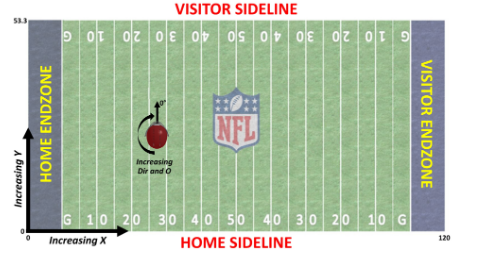

# Let's draw football pitch in matplotlib

In [ ]:
import matplotlib.patches as patches
from matplotlib.patches import Arc
from matplotlib import pyplot as plt
import matplotlib.patches as mpatches

# Change size of the figure
plt.rcParams['figure.figsize'] = [20, 16]
def drawPitch(width, height, color="w"):
    fig = plt.figure()
    ax = plt.axes(xlim=(-10, width + 30), ylim=(-15, height + 5))
    plt.axis('off')

    # Grass around pitch
    rect = patches.Rectangle((-10, -5), width + 40, height + 10, linewidth=1, facecolor='#3f995b', capstyle='round')
    ax.add_patch(rect)
    ###################

    # Pitch boundaries
    rect = plt.Rectangle((0, 0), width + 20, height, ec=color, fc="None", lw=2)
    ax.add_patch(rect)
    ###################

    # vertical lines - every 5 yards
    for i in range(21):
        plt.plot([10 + 5 * i, 10 + 5 * i], [0, height], c="w", lw=2)
    ###################
        
    # distance markers - every 10 yards
    for yards in range(10, width, 10):
        yards_text = yards if yards <= width / 2 else width - yards
        # top markers
        plt.text(10 + yards - 2, height - 7.5, yards_text, size=20, c="w", weight="bold")
        # botoom markers
        plt.text(10 + yards - 2, 7.5, yards_text, size=20, c="w", weight="bold", rotation=180)
    ###################

    # yards markers - every yard
    # bottom markers
    for x in range(20):
        for j in range(1, 5):
            plt.plot([10 + x * 5 + j, 10 + x * 5 + j], [1, 3], color="w", lw=3)

    # top markers
    for x in range(20):
        for j in range(1, 5):
            plt.plot([10 + x * 5 + j, 10 + x * 5 + j], [height - 1, height - 3], color="w", lw=3)

    # middle bottom markers
    y = (height - 18.5) / 2
    for x in range(20):
        for j in range(1, 5):
            plt.plot([10 + x * 5 + j, 10 + x * 5 + j], [y, y + 2], color="w", lw=3)

    # middle top markers
    for x in range(20):
        for j in range(1, 5):
            plt.plot([10 + x * 5 + j, 10 + x * 5 + j], [height - y, height - y - 2], color="w", lw=3)
    ###################

    # draw home end zone
    plt.text(2.5, (height - 10) / 2, "HOME", size=40, c="w", weight="bold", rotation=90)
    rect = plt.Rectangle((0, 0), 10, height, ec=color, fc="#0064dc", lw=2)
    ax.add_patch(rect)

    # draw away end zone    
    plt.text(112.5, (height - 10) / 2, "AWAY", size=40, c="w", weight="bold", rotation=-90)
    rect = plt.Rectangle((width + 10, 0), 10, height, ec=color, fc="#c80014", lw=2)
    ax.add_patch(rect)
    ###################
    
    # draw extra spot point
    # left
    y = (height - 3) / 2
    plt.plot([10 + 2, 10 + 2], [y, y + 3], c="w", lw=2)
    
    # right
    plt.plot([width + 10 - 2, width + 10 - 2], [y, y + 3], c="w", lw=2)
    ###################
    
    # draw goalpost
    goal_width = 6 # yards
    y = (height - goal_width) / 2
    # left
    plt.plot([0, 0], [y, y + goal_width], "-", c="y", lw=10, ms=20)
    # right
    plt.plot([width + 20, width + 20], [y, y + goal_width], "-", c="y", lw=10, ms=20)
    
    return fig, ax

fig, ax = drawPitch(100, 53.3)

# Load tracking data

For simplicity I use data only from 2018

In [ ]:
import pandas as pd
df = pd.read_csv("/kaggle/input/nfl-big-data-bowl-2022/tracking2018.csv")
print(df)

games_ids = {}
games = df.groupby(by=["gameId"])
for game, data in games:
    games_ids[game] = list(set(data.playId.tolist()))

# Prepare data for visualization

In [ ]:
def extract_one_game(game_id, play_id):
    game = df[(df.gameId == game_id) & (df.playId == play_id)]
    home = {}
    away = {}
    balls = []
    
    players = game.sort_values(['frameId'], ascending=True).groupby('nflId')
    for id, dx in players:
        jerseyNumber = int(dx.jerseyNumber.iloc[0])
        if dx.team.iloc[0] == "home":
            home[jerseyNumber] = list(zip(dx.x.tolist(), dx.y.tolist()))
        elif dx.team.iloc[0] == "away":
            away[jerseyNumber] = list(zip(dx.x.tolist(), dx.y.tolist()))


    ball_df = game.sort_values(['frameId'], ascending=True) 
    ball_df = ball_df[ball_df.team == "football"]
    balls = list(zip(ball_df.x.tolist(), ball_df.y.tolist()))
    return home, away, balls

# Function animating tracking data
I didn't find information about tracking data frequency, so I arbitrary chose 10Hz (one frame per 100ms), which looks smooth

In [ ]:
from matplotlib import animation
from IPython.display import HTML
def animate_one_play(game_id, play_id):
    fig, ax = drawPitch(100, 53.3)
    
    home, away, balls = extract_one_game(game_id, play_id)

    team_left, = ax.plot([], [], 'o', markersize=20, markerfacecolor="r", markeredgewidth=2, markeredgecolor="white", zorder=7)
    team_right, = ax.plot([], [], 'o', markersize=20, markerfacecolor="b", markeredgewidth=2, markeredgecolor="white", zorder=7)
    ball, = ax.plot([], [], 'o', markersize=10, markerfacecolor="black", markeredgewidth=2, markeredgecolor="white", zorder=7)
    drawings = [team_left, team_right, ball]

    def init():
        team_left.set_data([], [])
        team_right.set_data([], [])
        ball.set_data([], [])
        return drawings

    def draw_teams(i):
        X = []
        Y = []
        for k, v in home.items():
            x, y = v[i]
            X.append(x)
            Y.append(y)
        team_left.set_data(X, Y)
        
        X = []
        Y = []
        for k, v in away.items():
            x, y = v[i]
            X.append(x)
            Y.append(y)
        team_right.set_data(X, Y)

    def animate(i):
        draw_teams(i)
        
        x, y = balls[i]
        ball.set_data([x, y])
        return drawings
    
    # !May take a while!
    anim = animation.FuncAnimation(fig, animate, init_func=init,
                                   frames=len(balls), interval=100, blit=True)

    return HTML(anim.to_html5_video())


# Let's animate single play!

In [ ]:
animate_one_play(2018123000, 36)

# Let's add some interactivity
From provided dropdown widgets you can choose a demanded game.

**Animation's creation can take a while (depending on play's length - sometimes even up to 60s, so don't give up after clicking start)**

In [ ]:
import pandas as pd
import ipywidgets as widgets
from IPython.display import display,clear_output
from ipywidgets import Output, Button

output = Output()
start = Button(description="Start")
plays_widget = widgets.Dropdown(
    options=list(games_ids.keys()),
    value=list(games_ids.keys())[0],
    description='Game id:',
    disabled=False,
)
games_widget = widgets.Dropdown(
    options=games_ids[list(games_ids.keys())[0]],
    value=games_ids[list(games_ids.keys())[0]][0],
    description='Play id:',
    disabled=False,
)
def click_start(b):
    with output:
        clear_output()
        display(animate_one_play(plays_widget.value, games_widget.value))
       
start.on_click(click_start)
def on_change(change):
    with output:
        games_widget.options = games_ids[change.owner.value]

plays_widget.observe(on_change)

display(plays_widget, games_widget, start, output)

# Summary 
I hope you're gonna enjoy my notebook. The above code can be easily used within your pipeline. Obviously, more features (like players' directions) can be added to the plot, but I think for illustration purposes, current features are the most significant. I truly believe:

> The greatest value of a picture is when it forces us to notice what we never expected to see.
> 
and hope my dataViz will allow you to better understand the problem and create better agents.

# **Can't wait to see your feedback - I will truly appreciate your comments and try to improve my work! Good luck in the competition!**